### Generates a data base of responses for each trail for the single units. 

#### Run this notebook after creating the /PlaybackPkl files. For Julie's data these were made by translating the h5 files  using readUnith5_file.ipynb

#### You should only have to modify the rootPath in cell 2 for this notebook to work.


In [1]:
# Dependencies 
import os
import glob
import re
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle as pk
from scipy.stats import t
from sklearn.decomposition import PCA


### Set Paths
Note that it is assumed that you have data directory accessible from the rootPath

In [2]:
rootPath = '/Users/frederictheunissen/Google Drive/My Drive/julie/'
pklPath = 'pkl'


# The 6 birds from Julie data set
birds = ['BlaBro09xxF', 'GreBlu9508M', 'WhiBlu5396M', 'LblBlu2028M', 'WhiWhi4522M', 'YelBlu6903F']

### Functions

In [3]:
# These 3 z_score_stim functions could be combinned into 1.

def calc_zscore_stim(stimName):
    global dfRelTime
    
    rows = []
    # This loop finds all rows that match but there should only be one.
    for index, row in dfRelTime.iterrows():
        if row['file'] == stimName:
            rows.append(row)
    if (len(rows) != 1):
        print('Stimulus not found or too many')
        return 0.0, 1.0, 0
    
    # Choose one and only
    row = rows[0]
    
    # Calculates response diff for each stim
    spikeDiff = np.zeros(row['nTrials'])
    for it in range(row['nTrials']):
        spikeDiff[it] = np.sum((row['spikeTimes'][it] >= 0) & (row['spikeTimes'][it] < 0.5)) - np.sum((row['spikeTimes'][it] >= -0.5) & (row['spikeTimes'][it] < 0)) 
           
    # Calculate z-score and pvalue
    if (row['nTrials'] > 1) :
        sdiffSD = np.std(spikeDiff, ddof=1)
        if sdiffSD == 0:
            spikeDiff[0] += 1
            sdiffSD = np.std(spikeDiff, ddof=1)

        zscore = np.mean(spikeDiff)/sdiffSD
        if (zscore < 0.0):
            pvalue = (t.cdf(zscore*np.sqrt(row['nTrials']), row['nTrials']))*2.0
        else:
            pvalue = (1.0 - t.cdf(zscore*np.sqrt(row['nTrials']), row['nTrials']))*2.0
    else:
        zscore = 0
        pvalue = 1.0
        
    return zscore, pvalue, row['nTrials']

def calc_zscore_category(catName):
    global dfRelTime
    
    rows = []
    # This loop finds all rows that match but there should only be one.
    
    nTotal = 0
    for index, row in dfRelTime.iterrows():
        if row['call_type'] == catName:
            rows.append(row)
            nTotal += row['nTrials']
    if (nTotal == 0):
        return 0.0, 1.0, nTotal
    
    spikeDiff = np.zeros(nTotal)
    itot = 0
    for row in rows:
        for it in range(row['nTrials']):
            spikeDiff[itot] = np.sum((row['spikeTimes'][it] >= 0) & (row['spikeTimes'][it] < 0.5)) - np.sum((row['spikeTimes'][it] >= -0.5) & (row['spikeTimes'][it] < 0)) 
            itot += 1
            
    # Calculate z-score and pvalue
    if (nTotal > 1) :
        sdiffSD = np.std(spikeDiff, ddof=1)
        if sdiffSD == 0:
            spikeDiff[0] += 1
            sdiffSD = np.std(spikeDiff, ddof=1)

        zscore = np.mean(spikeDiff)/sdiffSD
        if (zscore < 0.0):
            pvalue = (t.cdf(zscore*np.sqrt(row['nTrials']), row['nTrials']))*2.0
        else:
            pvalue = (1.0 - t.cdf(zscore*np.sqrt(row['nTrials']), row['nTrials']))*2.0
    else:
        zscore = 0
        pvalue = 1.0
        
    return zscore, pvalue, nTotal


def calc_zscore_all():  
    global dfRelTime

    # Loop through all stims and trials.
    nTotal = 0
    for index, row in dfRelTime.iterrows():
        nTotal += row['nTrials']
            
    spikeDiff = np.zeros(nTotal)
    itot = 0
    for index, row in dfRelTime.iterrows():
        for it in range(row['nTrials']):        
            # Spike difference first 500 ms
            spikeDiff[itot] = np.sum((row['spikeTimes'][it] >= 0) & (row['spikeTimes'][it] < 0.5)) - np.sum((row['spikeTimes'][it] >= -0.5) & (row['spikeTimes'][it] < 0)) 
            itot += 1

    # Calculate z-score and pvalue
    if (nTotal > 1) :
        sdiffSD = np.std(spikeDiff, ddof=1)
        if sdiffSD == 0:
            spikeDiff[0] += 1   # Add a spike to generate SD
            sdiffSD = np.std(spikeDiff, ddof=1)
            
        zscore = np.mean(spikeDiff)/sdiffSD
        if (zscore < 0.0):
            pvalue = (t.cdf(zscore*np.sqrt(nTotal), nTotal))*2.0
        else:
            pvalue = (1.0 - t.cdf(zscore*np.sqrt(nTotal), nTotal))*2.0
    else: 
        zscore = 0
        pvalue = 1.0
        
    return zscore, pvalue, nTotal

    
def load_playbackPkl(playbackPkl):
    global unitInfo, dfRelTime
                
    # Load unitInfo and data frames 
    pklFile = playbackPkl
    try:
        fileIn = open(pklFile, 'rb')
        try:
            unitInfo = pk.load(fileIn)
            dfAbsTime = pk.load(fileIn)
            dfRelTime = pk.load(fileIn)
            fileIn.close()
        except:
            print('Empty file: ', pklFile)
    except OSError as err:
        print("OS error: {0}".format(err))

    
    return
               



### Loop through data a fist time and make summary data frame w results

In [8]:
# These are the lists that will be filled with data for each row in the data fame.
birdList = []
siteList = []
unitList = []
stimList = []
callList = []
trialList = []
RList = []
zList = []
PCList = []

itKDE = 1000    # Number of points in the KDE for PCs
tInt = 5.0      # This is for a correction for KDEs... (see Unit_readh5_files)

kdeList = []
good_Calls = ['Ag', 'Be', 'DC', 'Di', 'LT', 'Ne', 'So', 'Te', 'Th', 'Wh']

for bird in birds:    
    # Find sites
    # Find pklfiles
    pklfiles = glob.glob(os.path.join(rootPath,pklPath,bird, "*.pkl"))
       
    # Loop through sites
    for playPkl in pklfiles:
        load_playbackPkl(playPkl)
            
        # Select only single units.
        if unitInfo['SpikeSNR'] < 5.0:
            continue
        
        # Get the site and unit name from the file name
        site_unit = playPkl.split('/')[-1]
        site_unit_split = site_unit.split('_')
        site = site_unit_split[0]+ '_' + site_unit_split[1]
        unit = site_unit.split(site)[1]
        unit = unit[1:-4]
                
        # Get a measure of auditory strength
        zTot, pTot, nTot = calc_zscore_all()
            
        # Select only units that have significant auditory responses
        if pTot > 0.01:
            continue
                               
        # Loop through call categories to get measure of call-type selectivity
        calls = dfRelTime['call_type'].unique()
        
        good_calls = [call for call in calls if call in good_Calls]
        ncalls = len(good_calls)
            
        if (ncalls == 0) :        # This happens if there is data for the other stims..
            continue
            
        # Generate PCs and Variance
        # Estimate the number of trials and number of stims with 5 or more trials.
        # This code can be beautified using better pandas syntax
            
        # Counting the number of trials and of kdes
        nTotal = 0
        nKDE = 0
        for index, row in dfRelTime.iterrows():
            # Ignore stims that are not vocalizations
            if row['call_type'] not in good_calls:
                continue
            nTotal += row['nTrials']
            if row['nTrials'] >=5: 
                nKDE += 1
                    
        # Stuffing the arrays with the information        
        spikeDiff = np.zeros(nTotal)
        kdeArray = np.zeros((nKDE, itKDE))                               
        itot = 0
        ikde = 0
        for index, row in dfRelTime.iterrows():
            # Ignore stims that are not vocalizations
            if row['call_type'] not in good_calls:
                continue
            # Get the difference in spike counts.   
            for it in range(row['nTrials']):
                spikeDiff[itot] = np.sum((row['spikeTimes'][it] >= 0) & (row['spikeTimes'][it] < 0.5)) - np.sum((row['spikeTimes'][it] >= -0.5) & (row['spikeTimes'][it] < 0)) 
                itot += 1
            # Get the KDE for the PC if more than 5 trials and data has spikes
            # Note that the KDE was not normalized correctly in readUnit_h5_File so it is fixed here.
            if row['nTrials'] >=5:
                if np.sum(np.concatenate(row['spikeTimes'])):
                    kdeArray[ikde,:] = row['spikeKDE'][0:itKDE]*tInt/row['nTrials']
                ikde += 1
            
        spikeDiffSD = spikeDiff.std()
        if spikeDiffSD == 0.0:
            spikeDIffSD = 1/nTotal
                
        kdeList.append(kdeArray)
            
        # Loop through single trials - this should be changed because pandas.append is very slow - it does realloc()           
        itot = 0
        for index, row in dfRelTime.iterrows():
            # Ignore stims that are not vocalizations
            if row['call_type'] not in good_calls:
                continue                
            for it in range(row['nTrials']): 
                birdList.append(bird)
                siteList.append(site)
                unitList.append(unit)
                stimList.append(row['file'])
                callList.append(row['call_type'])
                trialList.append(it)
                RList.append(spikeDiff[itot])
                zList.append(spikeDiff[itot]/spikeDiffSD)
                
                itot += 1

dfDataBase = pd.DataFrame(list(zip(birdList, siteList, unitList, stimList, callList, trialList, RList, zList)), columns=['bird', 'site', 'unit', 'stim', 'call', 'trial', 'R', 'z'] )

In [9]:
dfDataBase

,bird,site,unit,stim,call,trial,R,z
0,BlaBro09xxF,Site3_L2500R2300,e18_s1_ss2,WhiWhi1415_FAF_Ne_3-8-9.wav,Ne,0,-1.0,-0.549909
1,BlaBro09xxF,Site3_L2500R2300,e18_s1_ss2,WhiWhi1415_FAF_Ne_3-8-9.wav,Ne,1,0.0,0.000000
2,BlaBro09xxF,Site3_L2500R2300,e18_s1_ss2,WhiWhi1415_FAF_Ne_3-8-9.wav,Ne,2,1.0,0.549909
3,BlaBro09xxF,Site3_L2500R2300,e18_s1_ss2,WhiWhi1415_FAF_Ne_3-8-9.wav,Ne,3,-2.0,-1.099818
4,BlaBro09xxF,Site3_L2500R2300,e18_s1_ss2,WhiWhi1415_FAF_Ne_3-8-9.wav,Ne,4,0.0,0.000000
...,...,...,...,...,...,...,...,...
737125,YelBlu6903F,Site2_L1000R900,e20_s0_ss1,WhiWhi1415_FAF_DC_6-2-4.wav,DC,6,2.0,0.326913
737126,YelBlu6903F,Site2_L1000R900,e20_s0_ss1,WhiWhi1415_FAF_DC_6-2-4.wav,DC,7,4.0,0.653826
737127,YelBlu6903F,Site2_L1000R900,e20_s0_ss1,WhiWhi1415_FAF_DC_6-2-4.wav,DC,8,1.0,0.163457
737128,YelBlu6903F,Site2_L1000R900,e20_s0_ss1,WhiWhi1415_FAF_DC_6-2-4.wav,DC,9,1.0,0.163457


### Calculate and display PCs

In [10]:
# PCs of KDE
kdeAll = np.vstack(kdeList)

pcKDE = PCA(n_components=10)
kdePC = pcKDE.fit_transform(kdeAll)

print(pcKDE.explained_variance_ratio_)

[0.5810928  0.11250662 0.08432771 0.06997414 0.04038026 0.02912823
 0.01929992 0.01350074 0.01114977 0.00903286]


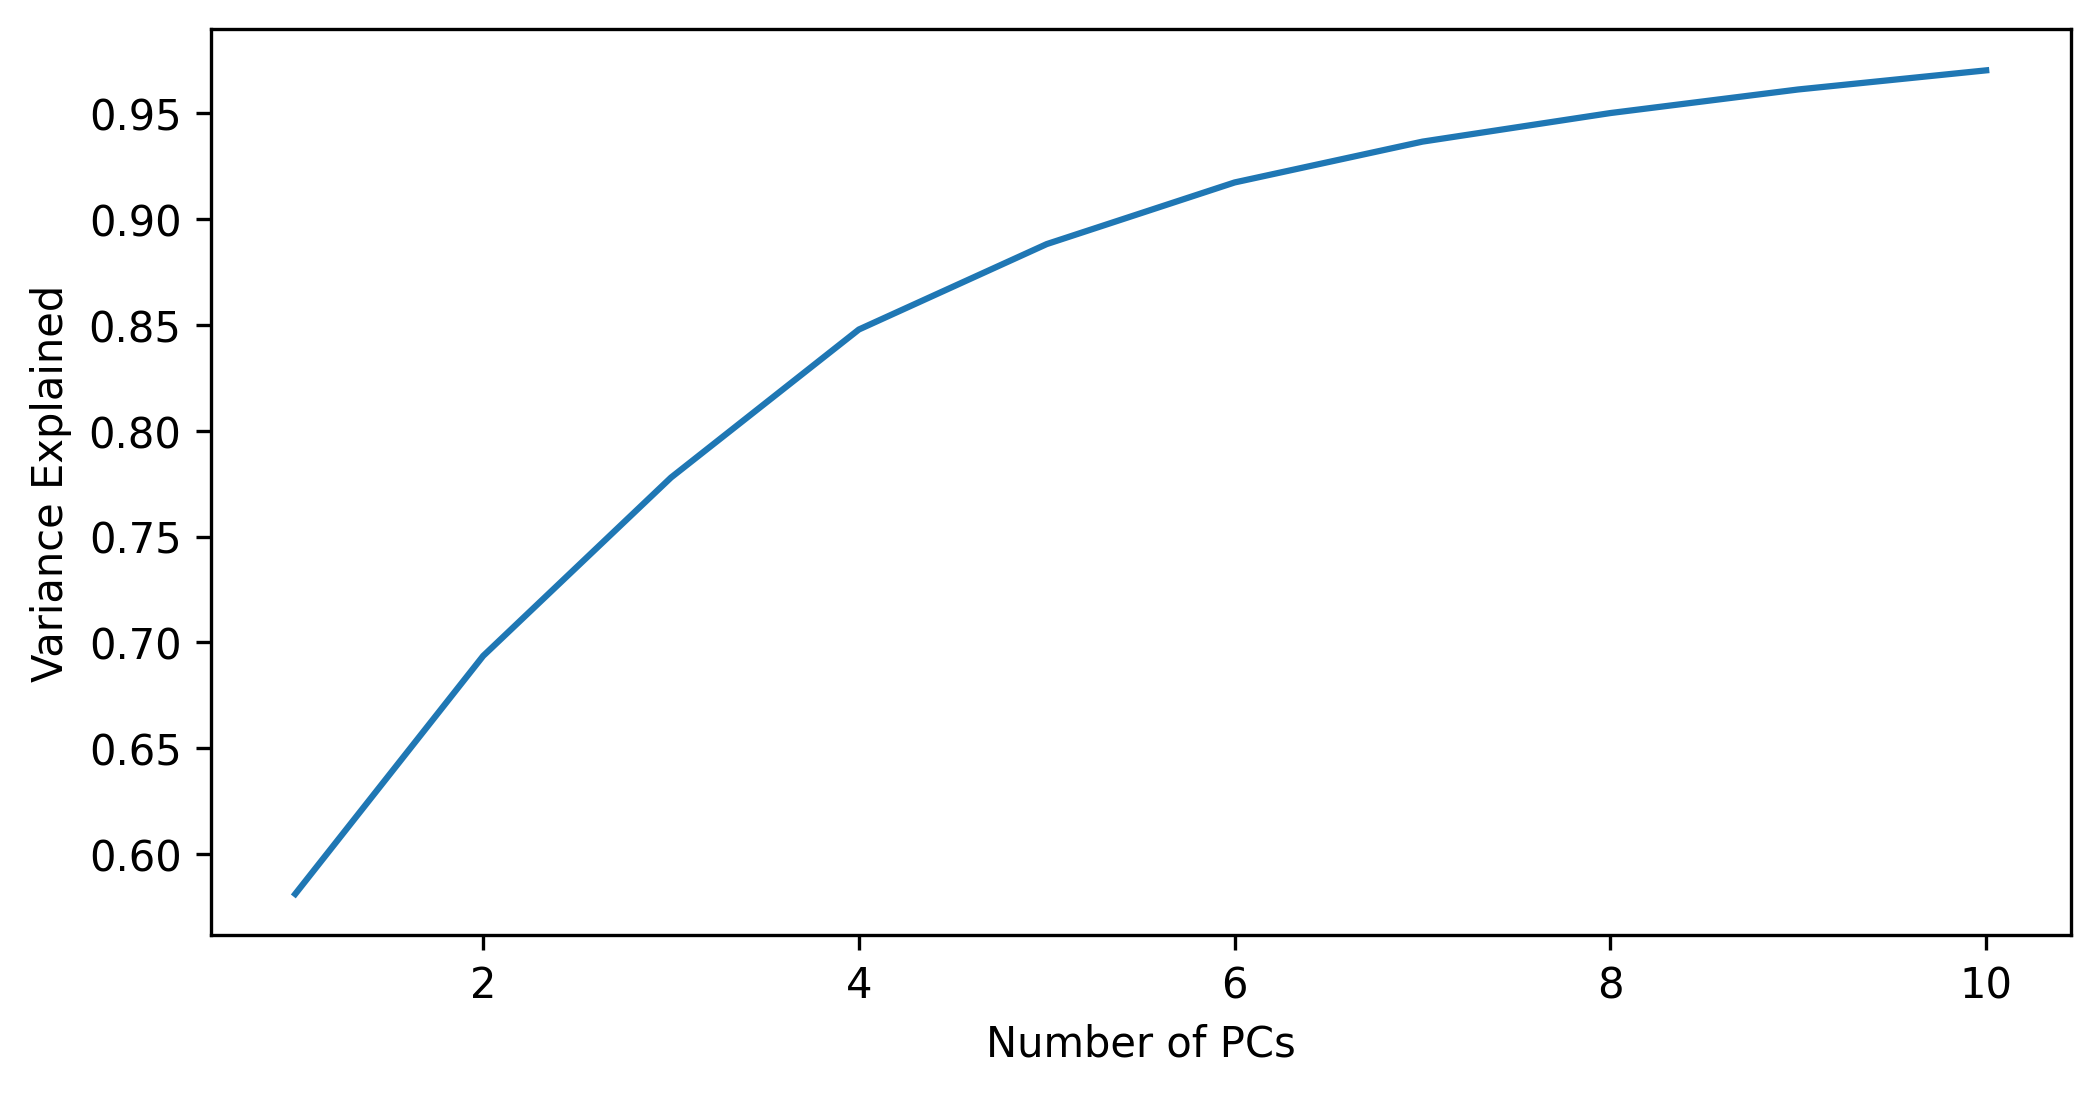

In [11]:
fig = plt.figure(figsize=(8,4), dpi = 300)

plt.plot(np.linspace(1,10, num=10), np.cumsum(pcKDE.explained_variance_ratio_))
plt.xlabel('Number of PCs')
plt.ylabel('Variance Explained')

plt.savefig('/Users/frederictheunissen/Desktop/PCAVarianceExplainedJulie.eps')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


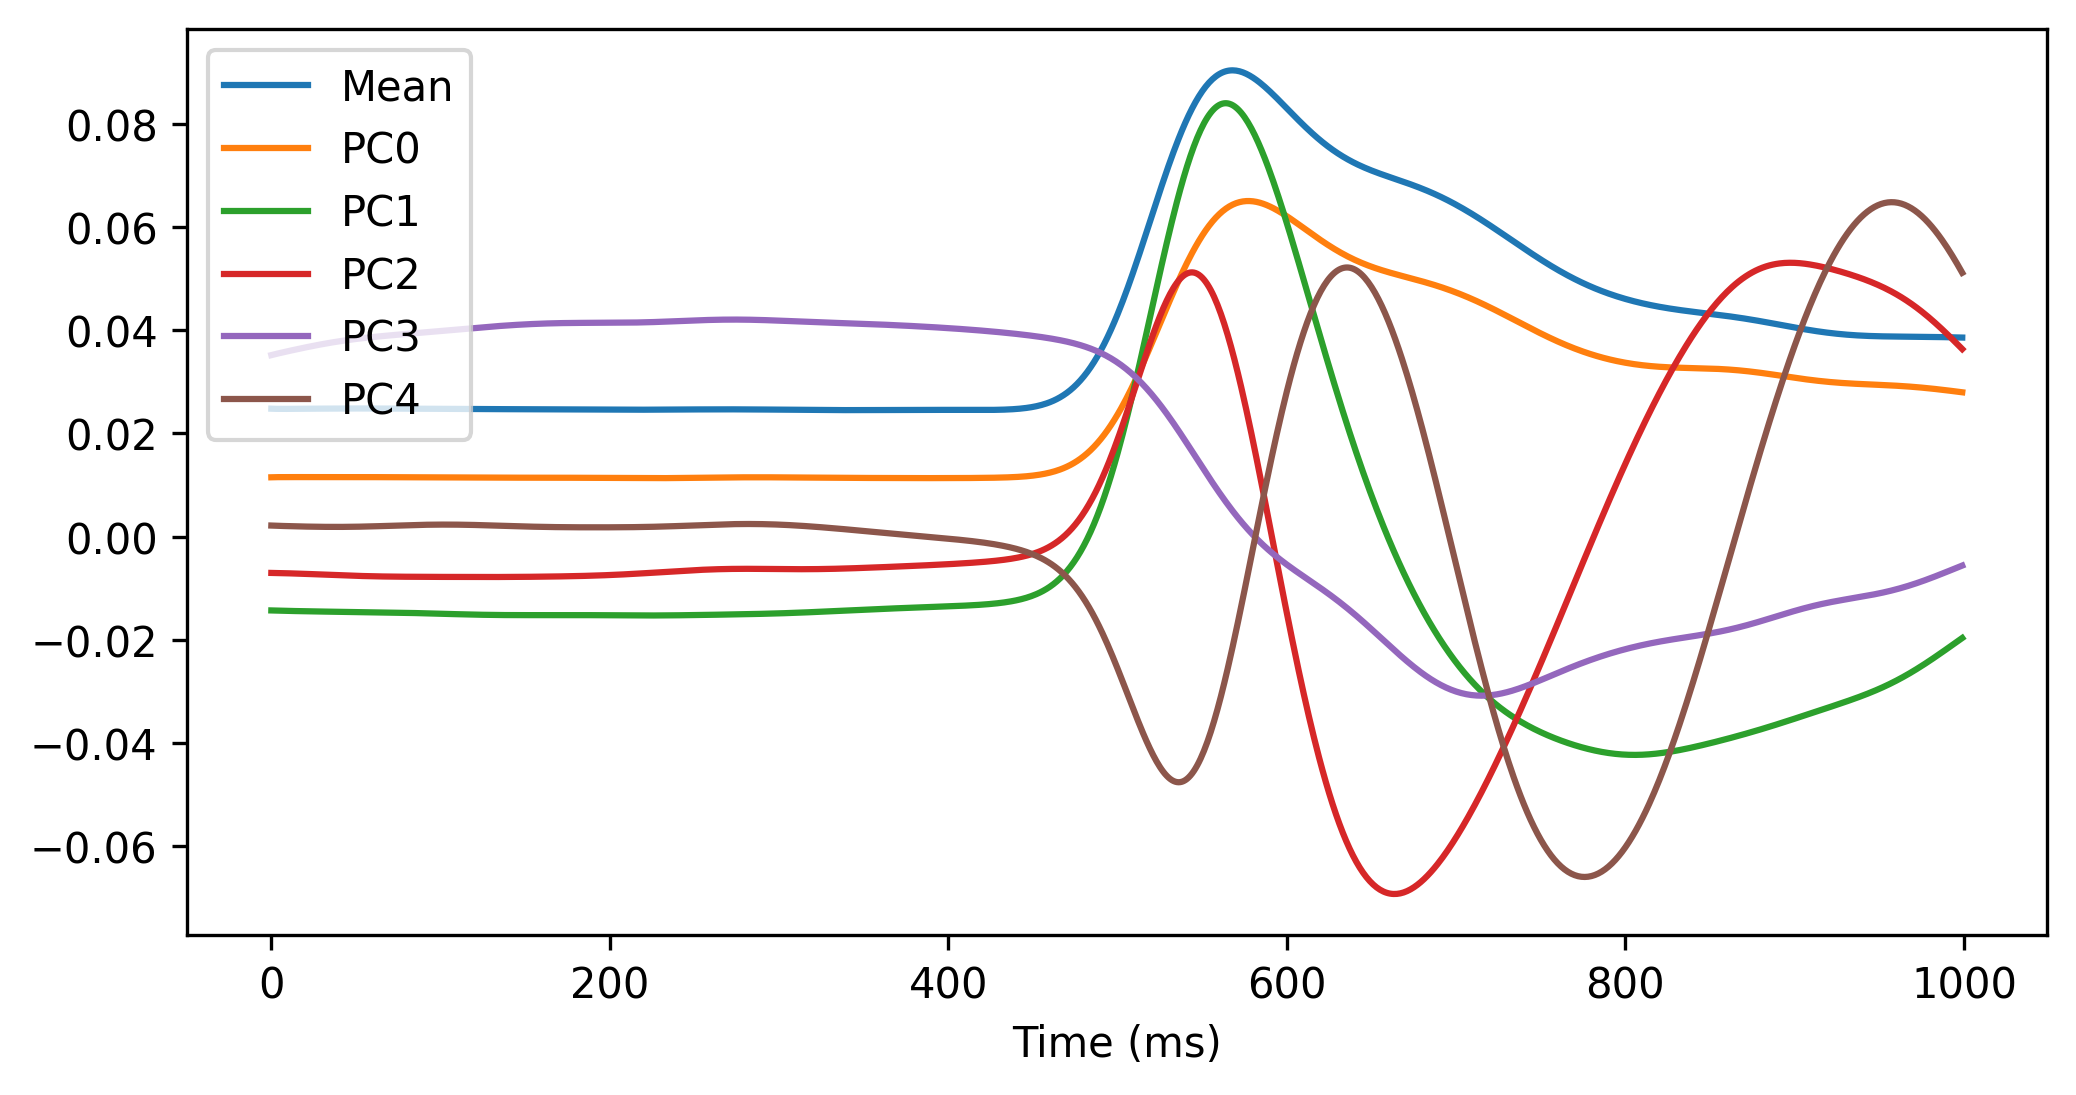

In [12]:

fig = plt.figure(figsize=(8,4), dpi=300)
plt.plot(pcKDE.mean_*.005, label='Mean')
plt.plot(pcKDE.components_[0,:], label='PC0')
plt.plot(pcKDE.components_[1,:], label='PC1')
plt.plot(pcKDE.components_[2,:], label='PC2')
plt.plot(pcKDE.components_[3,:], label='PC3')
plt.plot(pcKDE.components_[4,:], label='PC4')
plt.xlabel('Time (ms)')

plt.legend()

plt.savefig('/Users/frederictheunissen/Desktop/PCA5PCsJulie.eps')


### Skip the following section - it is for checking only

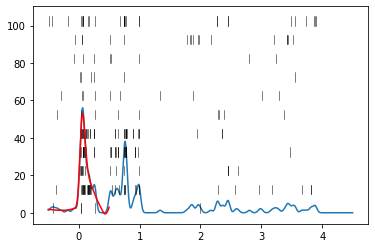

In [13]:
# First checking to see if we have the right data

plt.plot(row['tKDE'], row['spikeKDE']*tInt/row['nTrials'])
for it in range(row['nTrials']): 
    for spikeTime in row['spikeTimes'][it]:
        if spikeTime < -0.5:
            continue
        plt.plot([spikeTime, spikeTime], [10*it, 10*it +5], 'k-', linewidth=0.5)
        
# Reconstructed
KDERecon = np.dot(kdePC[-1,0:5], pcKDE.components_[0:5,:]) + pcKDE.mean_
plt.plot(row['tKDE'][0:1000], KDERecon, 'r')

In [14]:
# Checking out the computation
nPC = 5
# This code only works if you have a row defined.
fsamp = 1/(row['tKDE'][1]-row['tKDE'][0])

PCSum = np.zeros((1, nPC))
for it in range(row['nTrials']) :
    PCtrial = np.dot(pcKDE.components_[0:nPC,0:1000], -pcKDE.mean_)
    # print('Trial', it)
    for spikeTime in row['spikeTimes'][it]:
        if spikeTime < -0.5:
            continue
        iMin = np.argmin(np.abs(row['tKDE']-spikeTime))        
        if iMin < 1000:
            # print(spikeTime, '-->', iMin)
            PCtrial += fsamp*pcKDE.components_[0:nPC,iMin]
    print('Trial:', it, ' PC:', PCtrial)
    PCSum += PCtrial

kdeAVG = PCSum/row['nTrials']
print('AVG PC:', kdeAVG[0])

print('KDE PC:', kdePC[-1,0:nPC])

print(row['call_type'])

Trial: 0  PC: [-143.57580516   73.86061629   75.19247733   17.45590613 -150.0679078 ]
Trial: 1  PC: [ 905.10329454  739.52956116 -424.39264978 -188.20875974  191.8651488 ]
Trial: 2  PC: [  94.56266961  487.95311283  263.96559116   55.00223923 -210.75686075]
Trial: 3  PC: [ 516.17248718  780.32976695  189.36785004  -45.95788383 -208.05179895]
Trial: 4  PC: [ 735.61653344  696.79804898 -103.2270932  -140.72186247 -140.12951972]
Trial: 5  PC: [-191.54535395    9.97832085   24.76860847   -2.31491841 -102.05850646]
Trial: 6  PC: [-113.54449372  116.46795979   68.96771032   -6.78861129 -121.29415246]
Trial: 7  PC: [-114.11070843   53.31764065   11.66149637  -47.12978687 -146.23361161]
Trial: 8  PC: [-172.31950013   35.5103408     9.85037537  -22.97714926  -73.6459763 ]
Trial: 9  PC: [-151.79975947  158.46952819   89.32283227   18.81951579  -65.92361671]
Trial: 10  PC: [ 197.05906807  324.50708928   23.79232809   46.7017024  -102.69596968]
AVG PC: [ 141.965312    316.06563507   20.84268422  -

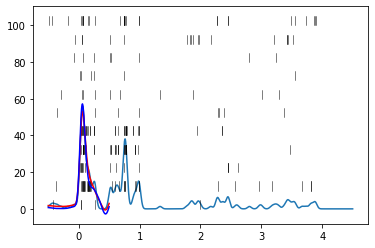

In [15]:
# Checking again

plt.plot(row['tKDE'], row['spikeKDE']*tInt/row['nTrials'])
for it in range(row['nTrials']): 
    for spikeTime in row['spikeTimes'][it]:
        if spikeTime < -0.5:
            continue
        plt.plot([spikeTime, spikeTime], [10*it, 10*it +5], 'k-', linewidth=0.5)
        
# Reconstructed
KDERecon = np.dot(kdePC[-1,0:5], pcKDE.components_[0:5,:]) + pcKDE.mean_
plt.plot(row['tKDE'][0:1000], KDERecon, 'r')

KDERecon2 = np.dot(kdeAVG[0], pcKDE.components_[0:5,:]) + pcKDE.mean_
plt.plot(row['tKDE'][0:1000], KDERecon2, 'b')

### Loop through the data again to calculate the PC coefficients for each trial.

In [16]:
row

file                                    WhiWhi1415_FAF_DC_6-2-4.wav
relation_short                                                  FAF
call_type                                                        DC
nTrials                                                          11
trialInd                                                         []
tStim             [-0.5, -0.4999590398951421, -0.499918079790284...
stimWav           [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
micWav                                                           []
spikeTimes        [[-0.4266803299999822, 0.03223562000002289, 0....
tKDE              [-0.5, -0.499, -0.498, -0.497, -0.496, -0.495,...
spikeKDE          [3.0574274299407485, 3.124709950737181, 3.1919...
tMic                                                             []
Name: 128, dtype: object

In [17]:
# Loop again through the data to fill in PC values
nPC = 5
pcList = []
for bird in birds:    
    # Find sites
    # Find pklfiles
    pklfiles = glob.glob(os.path.join(rootPath,pklPath,bird, "*.pkl"))
       
    # Loop through sites
    for playPkl in pklfiles:
        load_playbackPkl(playPkl)
            
        # Select only single units.
        if unitInfo['SpikeSNR'] < 5.0:
            continue
                
        # Get a measure of auditory strength
        zTot, pTot, nTot = calc_zscore_all()
            
        # Select only units that have significant auditory responses
        if pTot > 0.01:
            continue
                               
        # Loop through call categories to get measure of call-type selectivity
        calls = dfRelTime['call_type'].unique()
        good_calls = [call for call in calls if call in good_Calls]
        ncalls = len(good_calls)
            
        if (ncalls == 0) :        # This happens if there is data for the other stims..
            continue
            
        # Calculate the PC coefficients.
        nTotal = 0
        nKDE = 0
        for index, row in dfRelTime.iterrows():
            # Ignore stims that are not vocalizations
            
            # Ignore stims that are not vocalizations
            if row['call_type'] not in good_calls:
                continue
                
            PCSum = np.zeros((1, nPC))
            for it in range(row['nTrials']) :
                PCtrial = np.dot(pcKDE.components_[0:nPC,0:1000], -pcKDE.mean_)   # This is how we remove the mean response before projecting into PC
                for spikeTime in row['spikeTimes'][it]:                            
                    if spikeTime < -0.5:
                        continue
                    iMin = np.argmin(np.abs(row['tKDE']-spikeTime))
                    if iMin < 1000:
                        PCtrial += 1000.0*pcKDE.components_[0:nPC,iMin]   # A single spike needs to be worth 1000.0 because our sampling rate of 1ms.
                pcList.append(PCtrial)

            

In [18]:
print(len(pcList))
print(len(dfDataBase))

737130
737130


In [19]:
dfDataBase['PC']=pcList

### Save results

In [20]:
# Temp save of results
outPath = rootPath+'JulieDataBase.pkl'
fileOut = open(outPath,"wb")
pk.dump(dfDataBase, fileOut)
pk.dump(pcKDE, fileOut)
fileOut.close()